In [ ]:
!pip install -q ultralytics
!pip install -q torch torchvision torchaudio
!pip install -q pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00


#Mounting from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Unzipping

In [ ]:
import zipfile
import os

ZIP_PATH = "/content/drive/MyDrive/archive.zip"
EXTRACT_PATH = "/content/pet_dataset"   # extract into Colab workspace

os.makedirs(EXTRACT_PATH, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

print("✔ Extraction Done!")


✔ Extraction Done!


In [ ]:
DATASET = "/content/pet_dataset"

IMG_DIR = f"{DATASET}/images/images"     # contains .jpg files
XML_DIR = f"{DATASET}/annotations/xmls"  # contains .xml files
ANN_DIR = f"{DATASET}/annotations"

TRAINVAL = f"{ANN_DIR}/trainval.txt"
TESTTXT = f"{ANN_DIR}/test.txt"

print("Images in:", IMG_DIR)
print("Annotations in:", XML_DIR)


Images in: /content/pet_dataset/images/images
Annotations in: /content/pet_dataset/annotations/xmls


#Visualizing few images

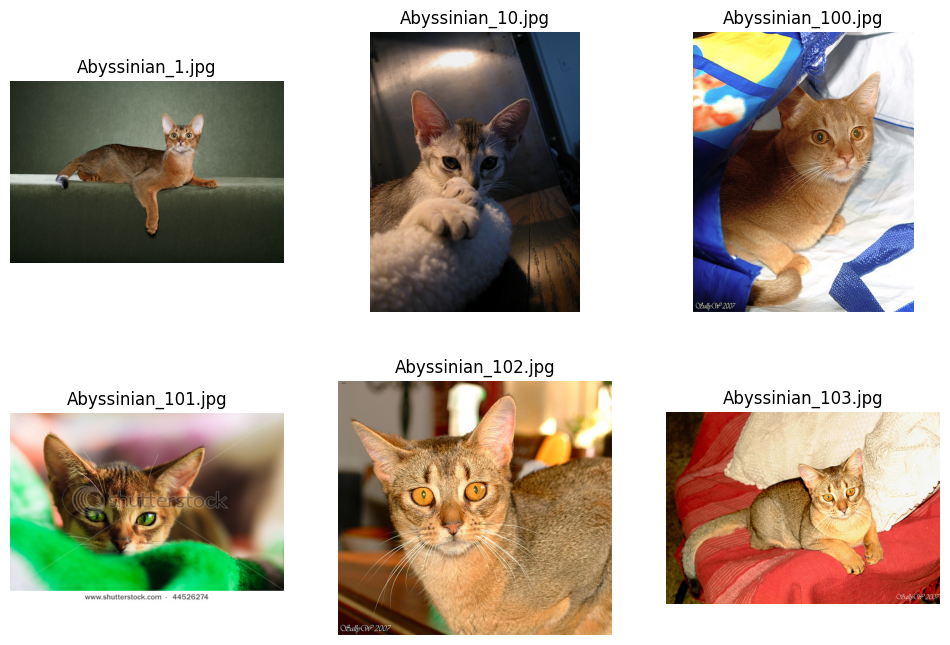

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# only use .jpg files
sample_imgs = [f for f in sorted(os.listdir(IMG_DIR)) if f.lower().endswith(".jpg")][:6]

plt.figure(figsize=(12,8))

for i, img_name in enumerate(sample_imgs):
    img_path = f"{IMG_DIR}/{img_name}"
    img = cv2.imread(img_path)

    if img is None:
        print("❌ Could not read:", img_path)
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2,3,i+1)
    plt.imshow(img_rgb)
    plt.title(img_name)
    plt.axis("off")

plt.show()


In [ ]:
import os

print(os.listdir("/content/pet_dataset"))
print("---- inside annotations ----")
print(os.listdir("/content/pet_dataset/annotations"))
print("---- inside annotations/annotations ----")
print(os.listdir("/content/pet_dataset/annotations/annotations"))


['annotations', 'images']
---- inside annotations ----
['annotations']
---- inside annotations/annotations ----
['trainval.txt', 'xmls', 'README', 'test.txt', 'trimaps', 'list.txt', '._trimaps']


In [ ]:
DATASET = "/content/pet_dataset"

IMG_DIR = f"{DATASET}/images/images"               # JPG files
ANN_DIR = f"{DATASET}/annotations/annotations"     # TXT + XML parent folder
XML_DIR = f"{ANN_DIR}/xmls"                        # XML files

TRAINVAL = f"{ANN_DIR}/trainval.txt"
TESTTXT  = f"{ANN_DIR}/test.txt"


In [ ]:
DATASET = "/content/pet_dataset"

# Correct & verified directories
IMG_DIR = f"{DATASET}/images/images"
ANN_DIR = f"{DATASET}/annotations/annotations"
XML_DIR = f"{ANN_DIR}/xmls"

TRAINVAL = f"{ANN_DIR}/trainval.txt"
TESTTXT  = f"{ANN_DIR}/test.txt"

print("Images in:", IMG_DIR)
print("XMLs in:", XML_DIR)
print("trainval.txt:", TRAINVAL)
print("test.txt:", TESTTXT)


Images in: /content/pet_dataset/images/images
XMLs in: /content/pet_dataset/annotations/annotations/xmls
trainval.txt: /content/pet_dataset/annotations/annotations/trainval.txt
test.txt: /content/pet_dataset/annotations/annotations/test.txt


In [ ]:
with open(TRAINVAL, "r") as f:
    trainval_list = [line.split()[0] + ".jpg" for line in f.read().splitlines()]

with open(TESTTXT, "r") as f:
    test_list = [line.split()[0] + ".jpg" for line in f.read().splitlines()]

print("Train+Val images:", len(trainval_list))
print("Test images:", len(test_list))


Train+Val images: 3680
Test images: 3669


In [ ]:
DATASET = "/content/pet_dataset"
IMG_DIR = "/content/pet_dataset/images/images"
ANN_DIR = "/content/pet_dataset/annotations/annotations"
XML_DIR = "/content/pet_dataset/annotations/annotations/xmls"
TRAINVAL = "/content/pet_dataset/annotations/annotations/trainval.txt"
TESTTXT  = "/content/pet_dataset/annotations/annotations/test.txt"


In [ ]:
# Load raw file names
with open(TRAINVAL, "r") as f:
    raw_trainval = [line.split()[0] for line in f.read().splitlines()]

with open(TESTTXT, "r") as f:
    raw_test = [line.split()[0] for line in f.read().splitlines()]

# Filter only images that ACTUALLY exist
trainval_list = []
for name in raw_trainval:
    jpg = f"{IMG_DIR}/{name}.jpg"
    xml = f"{XML_DIR}/{name}.xml"
    if os.path.exists(jpg) and os.path.exists(xml):
        trainval_list.append(name + ".jpg")

test_list = []
for name in raw_test:
    jpg = f"{IMG_DIR}/{name}.jpg"
    xml = f"{XML_DIR}/{name}.xml"
    if os.path.exists(jpg) and os.path.exists(xml):
        test_list.append(name + ".jpg")

print("Filtered Train+Val:", len(trainval_list))
print("Filtered Test:", len(test_list))


Filtered Train+Val: 3671
Filtered Test: 0


In [ ]:
from sklearn.model_selection import train_test_split

train_list, val_list = train_test_split(trainval_list, test_size=0.1, random_state=42)

print("Train:", len(train_list))
print("Val:", len(val_list))


Train: 3303
Val: 368


In [ ]:
for split in ["train", "val"]:
    os.makedirs(f"yolo/{split}/images", exist_ok=True)
    os.makedirs(f"yolo/{split}/labels", exist_ok=True)


In [ ]:
import xml.etree.ElementTree as ET

def xml_to_yolo(xml_path, w, h):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    lines = []
    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        xc = (xmin + xmax) / 2 / w
        yc = (ymin + ymax) / 2 / h
        ww = (xmax - xmin) / w
        hh = (ymax - ymin) / h

        lines.append(f"0 {xc} {yc} {ww} {hh}")

    return "\n".join(lines)


In [ ]:
import shutil
import cv2

def prepare(split_list, split_name):
    for img_name in split_list:
        img_path = f"{IMG_DIR}/{img_name}"
        xml_path = f"{XML_DIR}/{img_name.replace('.jpg', '.xml')}"

        if not os.path.exists(img_path) or not os.path.exists(xml_path):
            print("Skipping missing file:", img_name)
            continue

        # copy image
        shutil.copy(img_path, f"yolo/{split_name}/images/{img_name}")

        # create label
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        yolo_label = xml_to_yolo(xml_path, w, h)

        with open(f"yolo/{split_name}/labels/{img_name.replace('.jpg','.txt')}", "w") as f:
            f.write(yolo_label)

# build YOLO dataset
prepare(train_list, "train")
prepare(val_list, "val")

print("✔ YOLO Dataset Ready!")


✔ YOLO Dataset Ready!


In [ ]:
yaml_text = """
path: yolo

train: train/images
val: val/images

nc: 1
names: ["pet"]
"""

with open("pet.yaml", "w") as f:
    f.write(yaml_text)

print("✔ pet.yaml created")


✔ pet.yaml created


Training yolo v8

In [ ]:
from ultralytics import YOLO

# load small YOLOv8 model
model = YOLO("yolov8s.pt")

# train on your custom dataset
model.train(
    data="pet.yaml",
    epochs=5,
    imgsz=224,
    batch=8
)


Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pet.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b0bbfc11ee0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
metrics = model.val()
print(metrics)


Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1622.9±813.1 MB/s, size: 118.9 KB)
val: Scanning /content/yolo/val/labels.cache... 694 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 694/694 102.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 44/44 9.4it/s 4.7s
                   all        694        694      0.982      0.968      0.993      0.817
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b0bb5617e00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precisio

In [ ]:
import random
import os

sample_img = random.choice(os.listdir("yolo/val/images"))
sample_path = f"yolo/val/images/{sample_img}"

results = model.predict(sample_path, save=True)
results



image 1/1 /content/yolo/val/images/great_pyrenees_185.jpg: 160x224 1 pet, 165.9ms
Speed: 2.6ms preprocess, 165.9ms inference, 4.9ms postprocess per image at shape (1, 3, 160, 224)
Results saved to /content/runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'pet'}
 obb: None
 orig_img: array([[[ 96,  96,  96],
         [ 96,  96,  96],
         [ 97,  97,  97],
         ...,
         [ 90,  92,  92],
         [ 90,  92,  92],
         [ 90,  92,  92]],
 
        [[ 98,  98,  98],
         [ 98,  98,  98],
         [ 99,  99,  99],
         ...,
         [ 88,  90,  90],
         [ 88,  90,  90],
         [ 88,  90,  90]],
 
        [[ 97,  97,  97],
         [100, 100, 100],
         [100, 100, 100],
         ...,
         [ 87,  89,  89],
         [ 87,  89,  89],
         [ 88,  90,  90]],
 
        ...,
 
        [[105, 105,  93],
         [106, 104,  96],
         [104, 102,  94],
         ...,
         [ 28,  25,  21],
         [ 19,  18,  14],
         [ 20,  21,  19]],
 
        [[103, 103,  91],
         [105, 103,  95],
         [104, 101,  96],
         ...,
         [ 24,  21,  


image 1/1 /content/yolo/val/images/pomeranian_131.jpg: 192x224 1 pet, 277.3ms
Speed: 8.4ms preprocess, 277.3ms inference, 8.2ms postprocess per image at shape (1, 3, 192, 224)

image 1/1 /content/yolo/val/images/miniature_pinscher_100.jpg: 192x224 1 pet, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 4.2ms postprocess per image at shape (1, 3, 192, 224)

image 1/1 /content/yolo/val/images/japanese_chin_180.jpg: 192x224 1 pet, 61.1ms
Speed: 1.0ms preprocess, 61.1ms inference, 5.8ms postprocess per image at shape (1, 3, 192, 224)

image 1/1 /content/yolo/val/images/Sphynx_158.jpg: 224x224 1 pet, 54.9ms
Speed: 1.1ms preprocess, 54.9ms inference, 3.9ms postprocess per image at shape (1, 3, 224, 224)


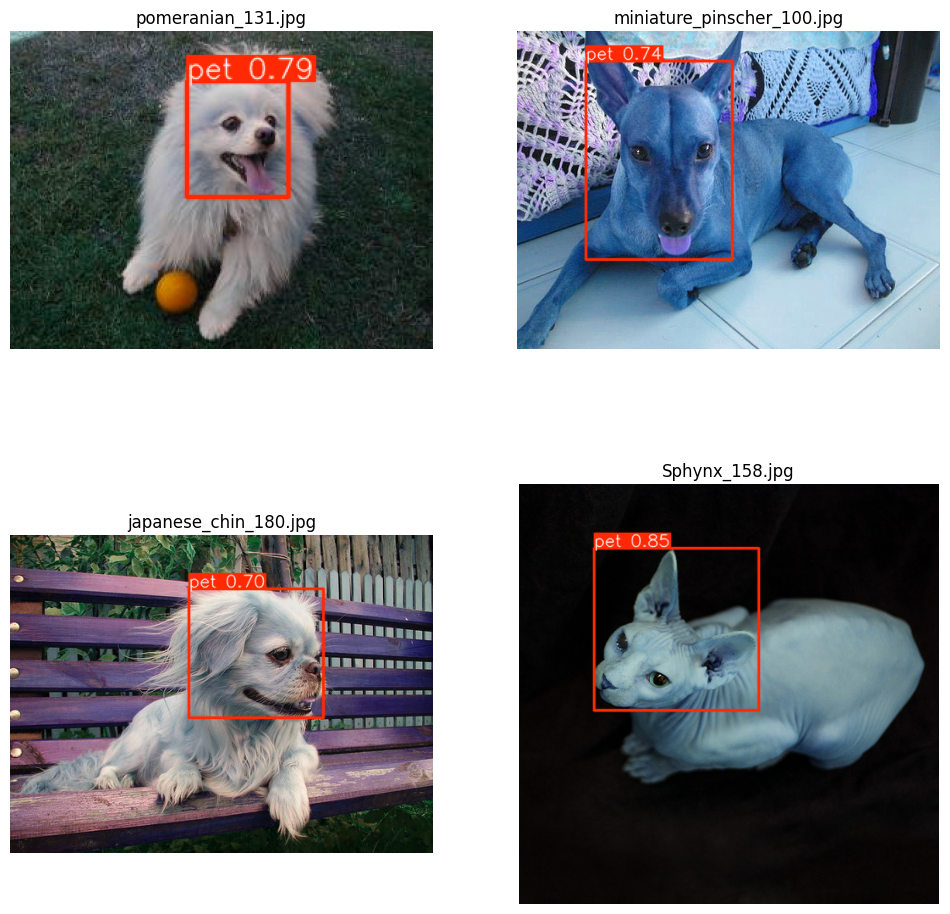

In [ ]:
import random
import matplotlib.pyplot as plt

val_imgs = os.listdir("yolo/val/images")
samples = random.sample(val_imgs, 4)

plt.figure(figsize=(12,12))

for i, img_name in enumerate(samples):
    img_path = f"yolo/val/images/{img_name}"
    results = model.predict(img_path)[0]
    plotted = results.plot()

    plt.subplot(2,2,i+1)
    plt.imshow(plotted)
    plt.title(img_name)
    plt.axis("off")

plt.show()


In [ ]:
metrics = model.val()

print("📌 YOLO Evaluation Metrics")
print("--------------------------")
print("Precision     :", metrics.box.mp)
print("Recall        :", metrics.box.mr)
print("mAP@50        :", metrics.box.map50)
print("mAP@50-95     :", metrics.box.map)


Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2404.5±819.2 MB/s, size: 132.3 KB)
val: Scanning /content/yolo/val/labels.cache... 694 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 694/694 873.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 44/44 10.6it/s 4.2s
                   all        694        694      0.982      0.968      0.993      0.817
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/runs/detect/val4
📌 YOLO Evaluation Metrics
--------------------------
Precision     : 0.9817212178983129
Recall        : 0.968299711815562
mAP@50        : 0.9930568675888021
mAP@50-95     : 0.8174863899025786
